In [3]:
using TaylorSeries

In [4]:
using Compat

In [5]:
const _ordenTaylor = 30 #Entiendo que este se puede cambiar de acuerdo con el problema
const _epsAbs = 1.0e-20 #Epsilon de la máquina.
GM1=1.0 #También por simplicidad comenzaré diciendo que esto es uno.
GM2=1.0 #Y que ambos cuerpos masivos tienen la misma masa. La masa m3 no afecta en el movimiento pues m3<<M1, M2

1.0

In [6]:
function iniCond1{T<:Real}(a::T) #En realidad no importa cuanto sea a
    x01=5.0
    y01=0.0
    vx01=0.0
    vy01=0.0 #Me pareció que por simplicidad podría poner a uno de los cuerpos en el origen
    return x01,y01,vx01,vy01
end

function iniCond2{T<:Real}(a::T)
    x02=10.0 #El siguiente a una distancia de 10 (km/cm/metros... ya lo decidiré después)
    y02=0.0
    vx02=0.0
    vy02=0.0
    return x02,y02,vx02,vy02
end

function iniCond3{T<:Real}(a::T)
    x03=15.0#El cuerpo pequeño lo ponemos en algún lugar entre M1 y M2.Probemos primero ponerlo, justamente enmedio.
    y03=5.0
    vx03=0.0
    vy03=0.0
    return x03,y03,vx03,vy03
end  

iniCond3 (generic function with 1 method)

In [7]:
function taylorStepper{T<:Real}( jetEqs::Function, vec01::Array{T,1},vec02::Array{T,1},vec03::Array{T,1}) 
    #Las entradas serán una función y tres vectores 
    #cuyas entradas serán las condiciones iniciales de velocidad y posición en x y en y
    #s sólo debe estar entre 1,2 ó 3

    n = length( vec01 )
    vec0T1 = Array(Taylor1{T},n)
    vec0T2 = Array(Taylor1{T},n)
    vec0T3 = Array(Taylor1{T},n)
   
    @simd for i in eachindex(vec01)
        @inbounds vec0T1[i] = Taylor1([vec01[i]], _ordenTaylor)
    end
     
    @simd for i in eachindex(vec02)
        @inbounds vec0T2[i] = Taylor1([vec02[i]], _ordenTaylor)
    end
     
    @simd for i in eachindex(vec03)
        @inbounds vec0T3[i] = Taylor1([vec03[i]], _ordenTaylor)
    end
    #Lo que entiendo de esta parte es que a cada entrada de vec0 se le convierte a formato de serie de Taylor.
    #vec0T será un vector cuyas entradas son series de Taylor y las componentes independientes de cada uno de ellas
    #son las componentes iniciales. Por ejemplo: vec0T=[x0+ ϑ(t²⁹),y0+ϑ(t²⁹),v0x+ϑ(t²⁹),v0y+ϑ(t²⁹)]
    vec1T1,vec1T2,vec1T3 = jetEqs( vec01,vec02,vec03 )
    #Aplicamos la función jetEqs a vec0.
    #Creo que esta es la que va a construir el resto de los coeficientes de cada serie.
    hh = Inf
    @simd for i in eachindex(vec1T1)
        @inbounds h1 = stepsize( vec1T1[i], _epsAbs ) #Stepsize regresa el error. Esta parte da un valor de h para 
        #cada una de las 4 series que se encuentran en el arreglo.
        hh= min( hh, h1 ) #Supongo que esto es para asegurarnos que el valor h1 no sea infinito.
    end
    hh1=hh
    hh = Inf
    @simd for i in eachindex(vec1T2)
        @inbounds h1= stepsize( vec1T2[i], _epsAbs )  
        hh= min( hh, h1 ) 
    end
    hh2=hh
    hh = Inf
    @simd for i in eachindex(vec1T3)
        @inbounds h1= stepsize( vec1T3[i], _epsAbs )  
        hh= min( hh, h1 ) 
    end
    hd=min(hh1,hh2,hh)
    
    @simd for i in eachindex(vec01)
        @inbounds vec01[i] = evaluate( vec1T1[i], hd ) #Evalúa vec1T (obtenido de Jeteqs) en el valor de error
        #y lo coloca en la entrada correspondiente de vec0 (donde teníamos los valores iniciales). Supongo que ahora
        #el vec0 es el valor de las posiciones y velocidades evaluadas en el tiempo hh. (es el primer avance en el
        #tiempo)
    end
    
    @simd for i in eachindex(vec02)
        @inbounds vec02[i] = evaluate(vec1T2[i], hd)
    end

    @simd for i in eachindex(vec03)
        @inbounds vec03[i] = evaluate( vec1T3[i], hd)
    end
    
    return hd,vec01,vec02,vec03 #El paso del tiempo es el promedio del paso ideal para los 3 cuerpos.
end
#Importante saber: Esta función regresa el paso de tiempo y los vectores de velocidades y posiciones de cada masa
#Evaluados en ese paso de tiempo.

taylorStepper (generic function with 1 method)

In [8]:
#Aquí no hay que hacer cambios.
#Calcula el tamaño del paso
function stepsize{T<:Real}(x::Taylor1{T}, epsilon::Float64)
    #Tiene como entradas una serie de Taylor y la epsilon de lxa máquina
    ord = x.order
    h = Inf
    for k in [ord-1, ord] #De las dos últimas entradas 
        kinv = 1.0/k
        aux = abs(x.coeffs[k+1])
        h = min(h, (epsilon/aux)^kinv)
        #Literalmente sigue la fórmula del valor h
    end
    return h
end

stepsize (generic function with 1 method)

In [9]:
#Aquí hay que cambiar que en vez de una variable de posición en x, tenemos 3; lo mismo para las posiciones en y 
#y las velocidades en x y en y

function jet{T<:Real}(vec1::Array{T,1}, vec2::Array{T,1}, vec3::Array{T,1}) #Hay tres vectores de entrada.

    xT1= Taylor1(vec1[1], _ordenTaylor) #Del primer cuerpo M1
    yT1= Taylor1(vec1[2], _ordenTaylor)
    vxT1= Taylor1(vec1[3], _ordenTaylor)
    vyT1= Taylor1(vec1[4], _ordenTaylor)
    
    xT2= Taylor1(vec2[1], _ordenTaylor) #Del segundo M2
    yT2= Taylor1(vec2[2], _ordenTaylor)
    vxT2= Taylor1(vec2[3], _ordenTaylor)
    vyT2= Taylor1(vec2[4], _ordenTaylor)

    xT3= Taylor1(vec3[1], _ordenTaylor) #Del tercero m3 (el orden realmente no importa jeje)
    yT3= Taylor1(vec3[2], _ordenTaylor)
    vxT3= Taylor1(vec3[3], _ordenTaylor)
    vyT3= Taylor1(vec3[4], _ordenTaylor)
    #Se guardan los valores iniciales en el lugar del término independiente. Pero a medida que avanza el loop de
    #abajo, se van llenando en estas variables, el resto de los términos de la serie de Taylor.
    for k = 0:_ordenTaylor-1
        knext = k+1 #Esto se necesita por el hecho de empezar desde cero.

        xTt1= Taylor1(xT1.coeffs[1:k+1], k) #Se "copian" los términos de la serie que ya se tenían
        yTt1= Taylor1(yT1.coeffs[1:k+1], k)
        vxTt1= Taylor1(vxT1.coeffs[1:k+1], k)
        vyTt1= Taylor1(vyT1.coeffs[1:k+1], k)
        
        xTt2= Taylor1(xT2.coeffs[1:k+1], k) 
        yTt2= Taylor1(yT2.coeffs[1:k+1], k)
        vxTt2= Taylor1(vxT2.coeffs[1:k+1], k)
        vyTt2= Taylor1(vyT2.coeffs[1:k+1], k) 
        
        xTt3= Taylor1(xT3.coeffs[1:k+1], k) 
        yTt3= Taylor1(yT3.coeffs[1:k+1], k)
        vxTt3= Taylor1(vxT3.coeffs[1:k+1], k)
        vyTt3= Taylor1(vyT3.coeffs[1:k+1], k)
        
        
        xDot1 = vxTt1 #Las ecuaciones
        yDot1 = vyTt1
        rrt1 = ( (xTt1-xTt2)^2 + (yTt1-yTt2)^2 )^(3/2)
        vxDot1 = -GM2*(xTt1-xTt2) / rrt1
        vyDot1 = -GM2*(yTt1-yTt2) / rrt1
        
                
        xDot2 = vxTt2 #Ojo:cambiar esta parte si quisiera modificar el código para que M1 y M2 fueran distintas.
        yDot2 = vyTt2 #Lo puse así para que la compu no calculara algo que ya estaba calculado.
        vxDot2 = -vxDot1
        vyDot2 = -vyDot1
        
                        
        xDot3 = vxTt3
        yDot3 = vyTt3 
        rrt3a=((xTt3-xTt1)^2 + (yTt3-yTt1)^2 )^(3/2)
        rrt3b=((xTt3-xTt2)^2 + (yTt3-yTt2)^2 )^(3/2)
        vxDot3 = -GM1*(((xTt3-xTt1)/ rrt3a)-((xTt3-xTt2)/ rrt3b)) #También cambiar esta parte. Agregar GM2.
        vyDot3 = -GM1*(((yTt3-yTt1)/ rrt3a)-((yTt3-yTt2)/ rrt3b)) 
        
        xT1.coeffs[knext+1]  = xDot1.coeffs[knext] / knext 
        yT1.coeffs[knext+1]  = yDot1.coeffs[knext] / knext 
        vxT1.coeffs[knext+1] = vxDot1.coeffs[knext] / knext
        vyT1.coeffs[knext+1] = vyDot1.coeffs[knext] / knext
        
                
        xT2.coeffs[knext+1]  = xDot2.coeffs[knext] / knext 
        yT2.coeffs[knext+1]  = yDot2.coeffs[knext] / knext 
        vxT2.coeffs[knext+1] = vxDot2.coeffs[knext] / knext
        vyT2.coeffs[knext+1] = vyDot2.coeffs[knext] / knext
        
                
        xT3.coeffs[knext+1]  = xDot3.coeffs[knext] / knext  
        yT3.coeffs[knext+1]  = yDot3.coeffs[knext] / knext 
        vxT3.coeffs[knext+1] = vxDot3.coeffs[knext] / knext
        vyT3.coeffs[knext+1] = vyDot3.coeffs[knext] / knext
    end
    
    return Taylor1[ xT1, yT1, vxT1, vyT1 ], Taylor1[ xT2, yT2, vxT2, vyT2 ], Taylor1[ xT3, yT3, vxT3, vyT3 ]
end
# Importante saber: esta función me sirve para taylorstepper

jet (generic function with 1 method)

In [10]:
function Integration(time_max::Float64, jetEqs::Function)
    # Por ahora no incluí la energía ni el momento angular. Después lo incluiré de ser necesario.
    t0 = 0.0
    x01, y01, vx01, vy01 = iniCond1(1) #Definí la función iniCond sólo para no tener que poner tantas variables
    x02, y02, vx02, vy02 = iniCond2(1) #como argumento de la funcíón keplerIntegration. 
    x03, y03, vx03, vy03 = iniCond3(1) 
   
    #Para graficar con Pyplot
    tV,xV1, yV1, vxV1, vyV1 = Float64[], Float64[], Float64[], Float64[], Float64[]
    xV2, yV2, vxV2, vyV2 = Float64[], Float64[], Float64[], Float64[]
    xV3, yV3, vxV3, vyV3 = Float64[], Float64[], Float64[], Float64[]
    
    push!(tV, t0) #Será que todas las series tienen el mismo paso de tiempo?
    push!(xV1, x01)
    push!(yV1, y01)
    push!(vxV1, vx01)
    push!(vyV1, vy01)
    push!(xV2, x02)
    push!(yV2, y02)
    push!(vxV2, vx02)
    push!(vyV2, vy02)
    push!(xV3, x03)
    push!(yV3, y03)
    push!(vxV3, vx03)
    push!(vyV3, vy03)
    
    A1=[x01, y01, vx01, vy01]
    A2=[x02, y02, vx02, vy02]
    A3=[x03, y03, vx03, vy03]
    dt= 1.0 
    while t0< time_max && dt>1.0e-8
        dt, (x1, y1, vx1, vy1),(x2, y2, vx2, vy2),(x3, y3, vx3, vy3) = taylorStepper(jetEqs,A1,A2,A3); #obtener
        #las series evaluadas en el tiempo t0. Se obtienen velocidades y posiciones en x y en y. También da h
        t0 += dt #Avanzar en el tiempo y volverlo a hacer (con el while)
        push!(tV,t0) #Ir llenando las listas
        push!(xV1,x1)
        push!(yV1,y1)
        push!(vxV1,vx1)
        push!(vyV1,vy1)
        A1=[x1,y1,vx1,vy1]
        push!(xV2,x2)
        push!(yV2,y2)
        push!(vxV2,vx2)
        push!(vyV2,vy2)
        A2=[x2,y2,vx2,vy2]       
        push!(xV3,x3)
        push!(yV3,y3)
        push!(vxV3,vx3)
        push!(vyV3,vy3)
        A2=[x3,y3,vx3,vy3]
    end

    return tV,xV1,yV1,xV2,yV2,xV3,yV3
end

Integration (generic function with 1 method)

In [21]:
tV, xV1, yV1, xV2, yV2, xV3, yV3  = Integration(170.0,jet)

([0.0,2.03021,7.93305,12.3988,15.7756,18.3289,20.2621,21.7279,22.8408,23.6869  …  151.212,152.14,153.287,154.708,156.467,158.647,161.35,164.703,168.864,174.03],[5.0,5.08336,5.70512,6.36877,7.0061,7.58687,8.10079,8.54723,8.93029,9.25616  …  12.9093,12.6582,12.3876,12.1005,11.803,11.5048,11.2226,10.9824,10.8263,10.8218],[0.0,0.0,0.0674438,0.220913,0.412251,0.614341,0.8123,0.998275,1.16856,1.32187  …  1.25976,1.12582,0.973191,0.800731,0.607973,0.395696,0.166833,-0.0719843,-0.307712,-0.515774],[10.0,9.91664,14.7676,14.4097,14.0035,13.5976,13.216,12.8699,12.5631,12.2951  …  17.3728,17.6874,18.0366,18.4208,18.8389,19.2862,19.7535,20.2232,20.6643,21.0225],[0.0,0.0,4.88195,4.69579,4.47974,4.25896,4.04685,3.85015,3.67172,3.51221  …  2.64091,2.76807,2.9123,3.07436,3.25424,3.45056,3.65964,3.87392,4.07919,4.24944],[15.0,14.9852,14.7676,14.4097,14.0035,13.5976,13.216,12.8699,12.5631,12.2951  …  17.3728,17.6874,18.0366,18.4208,18.8389,19.2862,19.7535,20.2232,20.6643,21.0225],[5.0,4.9926,4.88195,4.69

In [19]:
using PyPlot

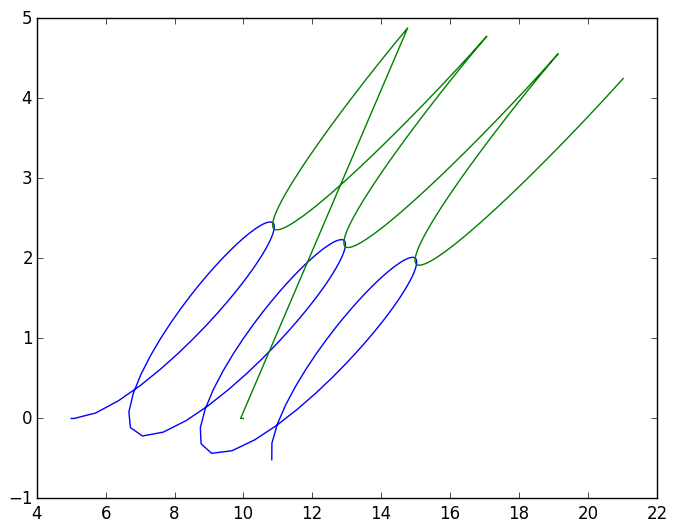

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fea671558d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fea67155b50>

In [22]:

plot(xV1,yV1,xV2,yV2)

La gráfica anterior se hizo escribiendo vxDot3 = -GM1*((xTt3-xTt1)/ rrt3a) y vyDot3 = -GM1*((yTt3-yTt1)/ rrt3a)(en la función jet). Esto para que se pudiera correr el proceso completo sin ningún error y ver si estaba modelando al menos los dos cuerpos grandes (que no dependen del tercero)... y al parecer sí! :)
La expresiones correctas son vxDot3 = -GM1*(((xTt3-xTt1)/ rrt3a)-((xTt3-xTt2)/ rrt3b))y vyDot3 = -GM1*(((yTt3-yTt1)/ rrt3a)-((yTt3-yTt2)/ rrt3b)). El problema aparece al dividir entre rrt3b, porque al parecer, de alguna forma se divide entre cero. Ya hice varias pruebas, y según yo, eso no pasa. No sé aún cómo resolver el problema, pero de hacerlo, habré terminado con esta parte.

In [12]:
tV, xV1, yV1, xV2, yV2, xV3, yV3  = Integration(170.0,jet) #Aquí ya corregí la expresión y escribí la correcta
#aparece el horrible error.

LoadError: ArgumentError("Division does not define a Taylor1 polynomial\n        or its first non-zero coefficient is Inf/NaN.\n        Order k=0 => coeff[1]=NaN.\n")
while loading In[12], in expression starting on line 1